### Non-dimensionalize with rated power and rated power RPMs, replace pressures with pressure ratios
### Add temperature correction
### Add mixture correction and SPECIFIC FUEL CONSUMPTION. Look up definition.

In [14]:
using Interpolations

### Sea Level Part Throttle Data (Fig. 3-21 Left)

For this we just need a 2D table providing $\tilde{P}_{std}(n,MAP)$

From the graph we see that the function $\tilde{P}_{std}(n,MAP)$ is linear in $MAP$. Therefore we need only two data points for each $n$: $(MAP_{1}(n), \tilde{P}_{std}(n,MAP_1(n)))$ and $(MAP_{2}(n), \tilde{P}_{std}(n, MAP_2(n)))$.

For $n > 2700$, if we were to simply extrapolate the values in the graph, power would increase indefinitely with engine speed, which we know is not realistic. To avoid this, we add two extra $n$ entries at 2800 and 2900 RPM, with power reaching a peak at 2700-2800 RPM, then decreasing at 2900 RPM, both for $MAP_1$ and $MAP_2$. $MAP_1$ and $MAP_2$ for these $n$ values are simply extrapolations. 

In [15]:
_rated = 2700
P_rated = 200

n_range = range(1800, 2700, step = 100)
n_range_ext = range(1800, 2900, step = 100)

MAP_std_1 = fill!(similar(n_range_ext), 17)
P̃_std_1 = [54 61 67 72 76 81 85 90 94.1 99.5 99.5 96.1] |> vec
MAP_std_2 = [25 25.55 26.15 26.88 27.3 28.1 28.75 28.7 28.65 28.6 28.55 28.50] |> vec
P̃_std_2 = [97.8 109.5 121.8 136 145.75 162 176 184 193 200 200 193] |> vec

12-element Vector{Float64}:
  97.8
 109.5
 121.8
 136.0
 145.75
 162.0
 176.0
 184.0
 193.0
 200.0
 200.0
 193.0

However, for a 2D table we need these two $MAP$ values to be the same across all values of $n$. So for each $n$, we construct a 1D linear interpolator, resample $\tilde{P}_{std}$ at two $MAP$ values, arbitrary but equal for all $n$, then build the 2D interpolator.

In [16]:
MAP_std_range = range(17, 30, length = 2)
P̃_std_samples = Array{Float64,2}(undef, (length(n_range_ext), length(MAP_std_range)))

for (i, n) in enumerate(n_range_ext)
    interp_P̃_std_1D = LinearInterpolation([MAP_std_1[i], MAP_std_2[i]], [P̃_std_1[i],P̃_std_2[i]], extrapolation_bc = Line())
    P̃_std_samples[i,:] = interp_P̃_std_1D.(MAP_std_range)
end

interp_P̃_std = extrapolate(scale(interpolate(P̃_std_samples, BSpline(Linear())), n_range_ext, MAP_std_range), Line())

12×2 extrapolate(scale(interpolate(::Matrix{Float64}, BSpline(Linear())), (1800:100:2900, 17.0:13.0:30.0)), Line()) with element type Float64:
 54.0  125.175
 61.0  134.743
 67.0  144.858
 72.0  156.211
 76.0  164.034
 81.0  175.865
 85.0  185.681
 90.0  194.444
 94.1  204.461
 99.5  212.129
 99.5  212.617
 96.1  205.639

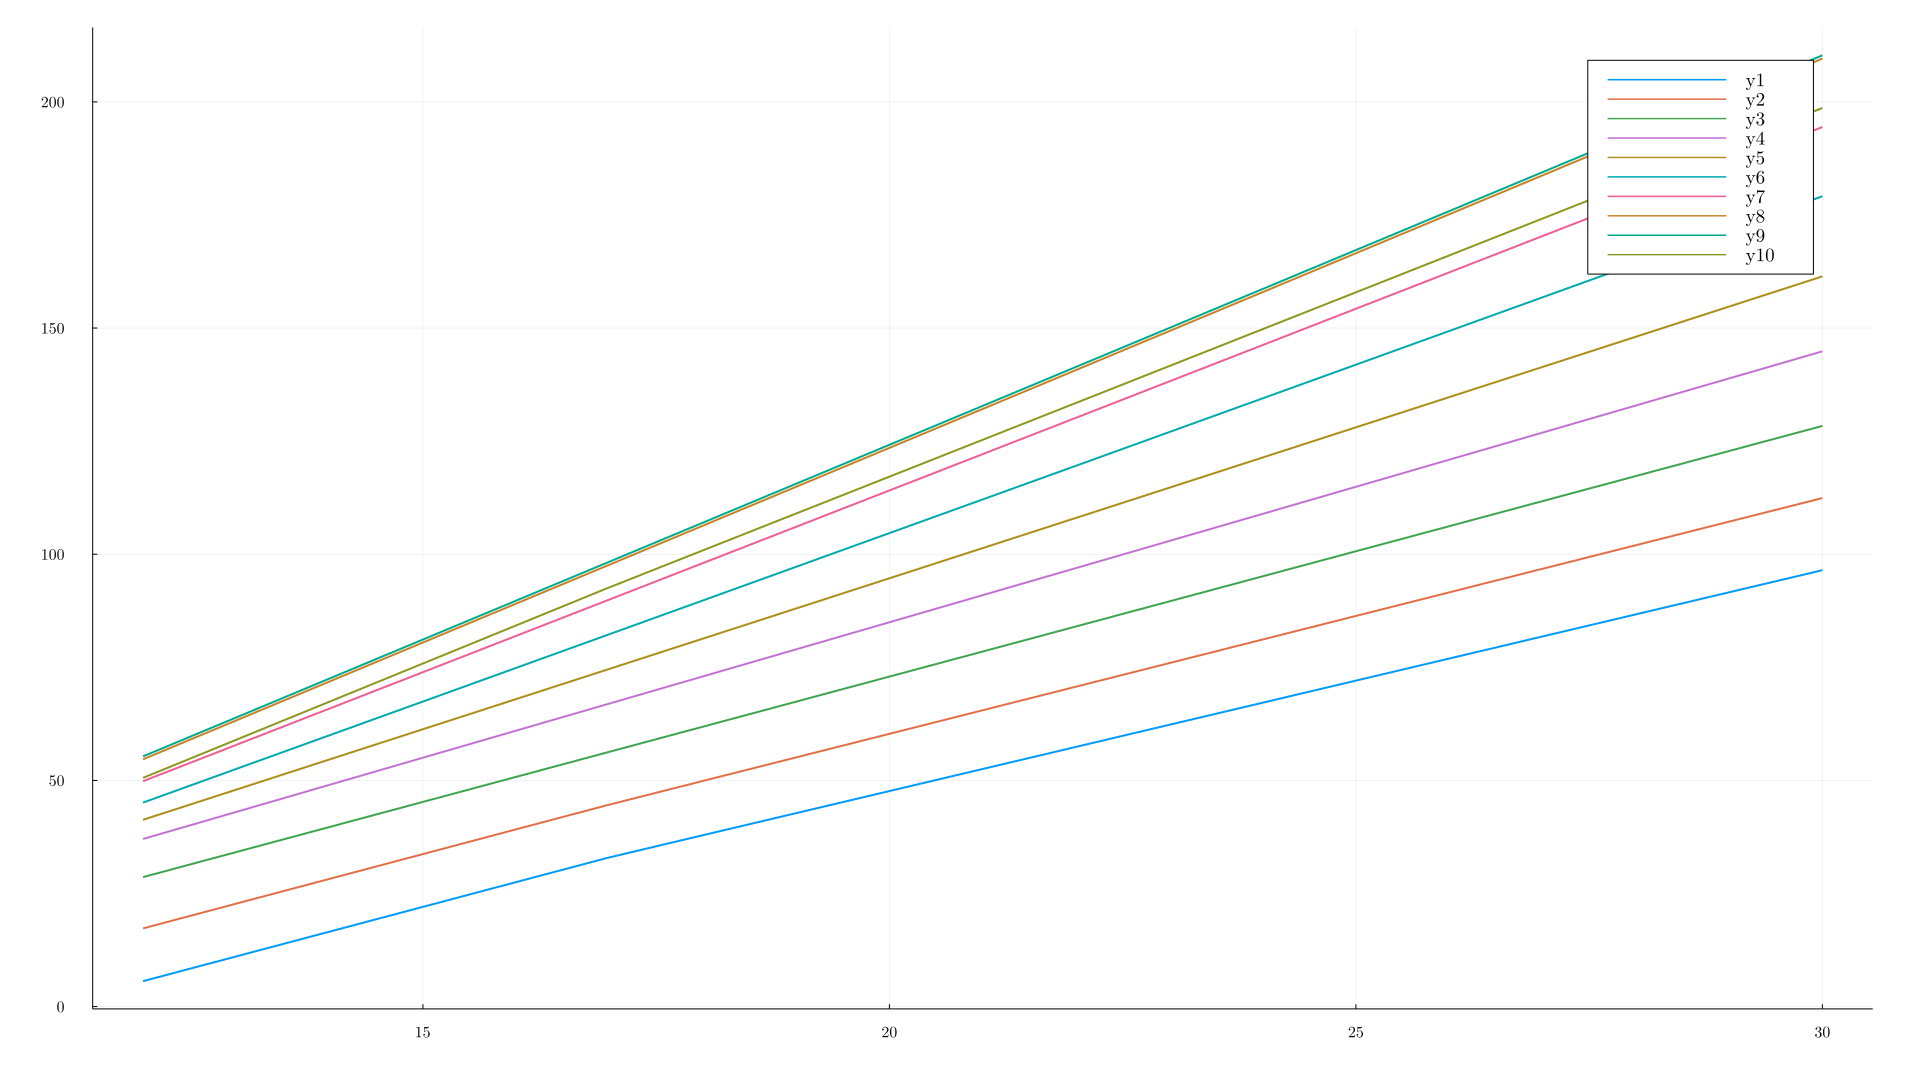

In [17]:
#plot minimum and maximum sea level power across RPM
using Plots
n_plot = range(1500, 3000, length = 10)
MAP_plot = range(12, 30, length = 30)
P̃_std_plot = [interp_P̃_std(n,MAP) for (n,MAP) in Iterators.product(n_plot, MAP_plot)]
plot(MAP_plot, P̃_std_plot')

### Full Throttle Data (Fig. 3-21, Right)


This graph is tricky, because the pressure altitude values in the x-axis are not linearly spaced. This means that the relations that appear linear in the graph are not actually so. In particular, $\tilde{P}_{wot}(h_{ISA})$ will not be linear. However, this makes sense! We know from theory that the wide-open throttle brake power has the following dependence with $p$ and $T$:

$$P \propto \dfrac{p}{\sqrt{T}}$$

By definition, $\tilde{P}(n, MAP, p) = P(n, MAP, p, T_{std})$. Therefore:
$$\tilde{P} \propto p$$

So, we should expect $\tilde{P}$ to be a linear function of $p$. Since $h_{ISA}(p)$ is not a linear function, the fact that $\tilde{P_{wot}}(h_{ISA})$ in the graph is not linear is not surprising. 

If we replace the $h$ values with actual $p$ values, computed according to the ISA law, then it should be safe to assume linearity between two points $(p_1, \tilde{P}_{wot, 1}(n, p_1))$ and $(p_2, \tilde{P}_{wot, 2}(n, p_2))$ when interpolating for any given $n$.

The same consideration should apply to the dependence of $MAP_{wot}$. We know that for a given $n$, $MAP$ should linearly follow $p$, not $h$. However, this non-linearity with $h$ is not as readily noticeable in the graph.


Let's first construct a 2D interpolator $p_{wot}(n, MAP)$, which we'll need later to find $p_{ref}$.

In [5]:

using Unitful, StructArrays
using Flight.Atmosphere: ISAData
using Flight.Geodesy: AltGeop

MAP_range_wot = range(12, 28, step = 2) #24 26 28
n_1_wot = 1800
n_2_wot = 2700

#take the pressure altitude values in kft read from the graph and convert them
#to meters
h_wot_1 = ustrip.(u"m", [22.25, 18.50, 15.4, 12.5, 9.75, 7.25, 5.1, 3.20, 1.2]*1000u"ft")
h_wot_2 = ustrip.(u"m", [21.75, 18.25, 15.0, 12.1, 9.50, 7.00, 4.7, 2.2, 0.60]*1000u"ft")

#compute the corresponding pressure values in Pa
p_wot_1 = StructArray(ISAData.(AltGeop.(h_wot_1))).p
p_wot_2 = StructArray(ISAData.(AltGeop.(h_wot_2))).p

#p_wot_1[i] represents the ambient pressure we would need to have to get the
#MAP_wot = MAP_range_wot[i] at 1800 RPM. p_wot_2 is the same for 2700
#RPM. 

#as a comparison:
@show p_wot_1[1], p_wot_2[1], MAP_range_wot[1] * 3386.389

#so we see that even at 1800RPM, MAP is noticeably below the actual ambient
#pressure. and higher RPM require slightly higher ambient pressure to achieve a
# given MAP, because the manifold vacuum increases with RPM

n_range = range(1800, 2700, step = 100)
p_wot_data = Array{Float64}(undef, length(n_range), length(MAP_range_wot))
for (i, MAP) in enumerate(MAP_range_wot)
    interp_p_wot_1D = LinearInterpolation([n_1_wot, n_2_wot], [p_wot_1[i], p_wot_2[i]], extrapolation_bc = Line())
    p_wot_data[:,i] = interp_p_wot_1D.(n_range)
end

interp_p_wot = extrapolate(scale(interpolate(p_wot_data, BSpline(Linear())), n_range, MAP_range_wot), Line())
# # @show interp_h_wot(1800, 26)

#to test this, we can read h for some n, MAP from the graph, and compute its
#p_ISA(h). then we see if we get the same value from interp_p_wot
@show interp_p_wot(2050, 24), ISAData(AltGeop(ustrip(u"m", 5000u"ft"))).p
@show interp_p_wot(2300, 12), ISAData(AltGeop(ustrip(u"m", 22000u"ft"))).p
@show interp_p_wot(2400, 28), ISAData(AltGeop(ustrip(u"m", 800u"ft"))).p
@show interp_p_wot(2200, 26), ISAData(AltGeop(ustrip(u"m", 2750u"ft"))).p
@show interp_p_wot(2200, 26), ISAData(AltGeop(ustrip(u"m", 2750u"ft"))).p
@show interp_p_wot(2000, 24), ISAData(AltGeop(ustrip(u"m", 5000u"ft"))).p
#it is reasonably approximate



(p_wot_1[1], p_wot_2[1], MAP_range_wot[1] * 3386.389) = (42337.92650709364, 43248.91549812639, 40636.668000000005)


(interp_p_wot(2050, 24), (ISAData(AltGeop(ustrip(u"m", 5000 * u"ft")))).p) = 

(84343.86408755137, 84307.26454059842)
(interp_p_wot(2300, 12), (ISAData(AltGeop(ustrip(u"m", 22000 * u"ft")))).p) = (42844.03150211183, 42791.45802214297)
(interp_p_wot(2400, 28), (ISAData(AltGeop(ustrip(u"m", 800 * u"ft")))).p) = (98433.99985205723, 98429.79664395095)
(interp_p_wot(2200, 26), (ISAData(AltGeop(ustrip(u"m", 2750 * u"ft")))).p) = (91646.18238012052, 91652.49615255932)
(interp_p_wot(2200, 26), (ISAData(AltGeop(ustrip(u"m", 2750 * u"ft")))).p) = (91646.18238012052, 91652.49615255932)
(interp_p_wot(2000, 24), (ISAData(AltGeop(ustrip(u"m", 5000 * u"ft")))).p) = (84273.53774275482, 84307.26454059842)


(84273.53774275482, 84307.26454059842)

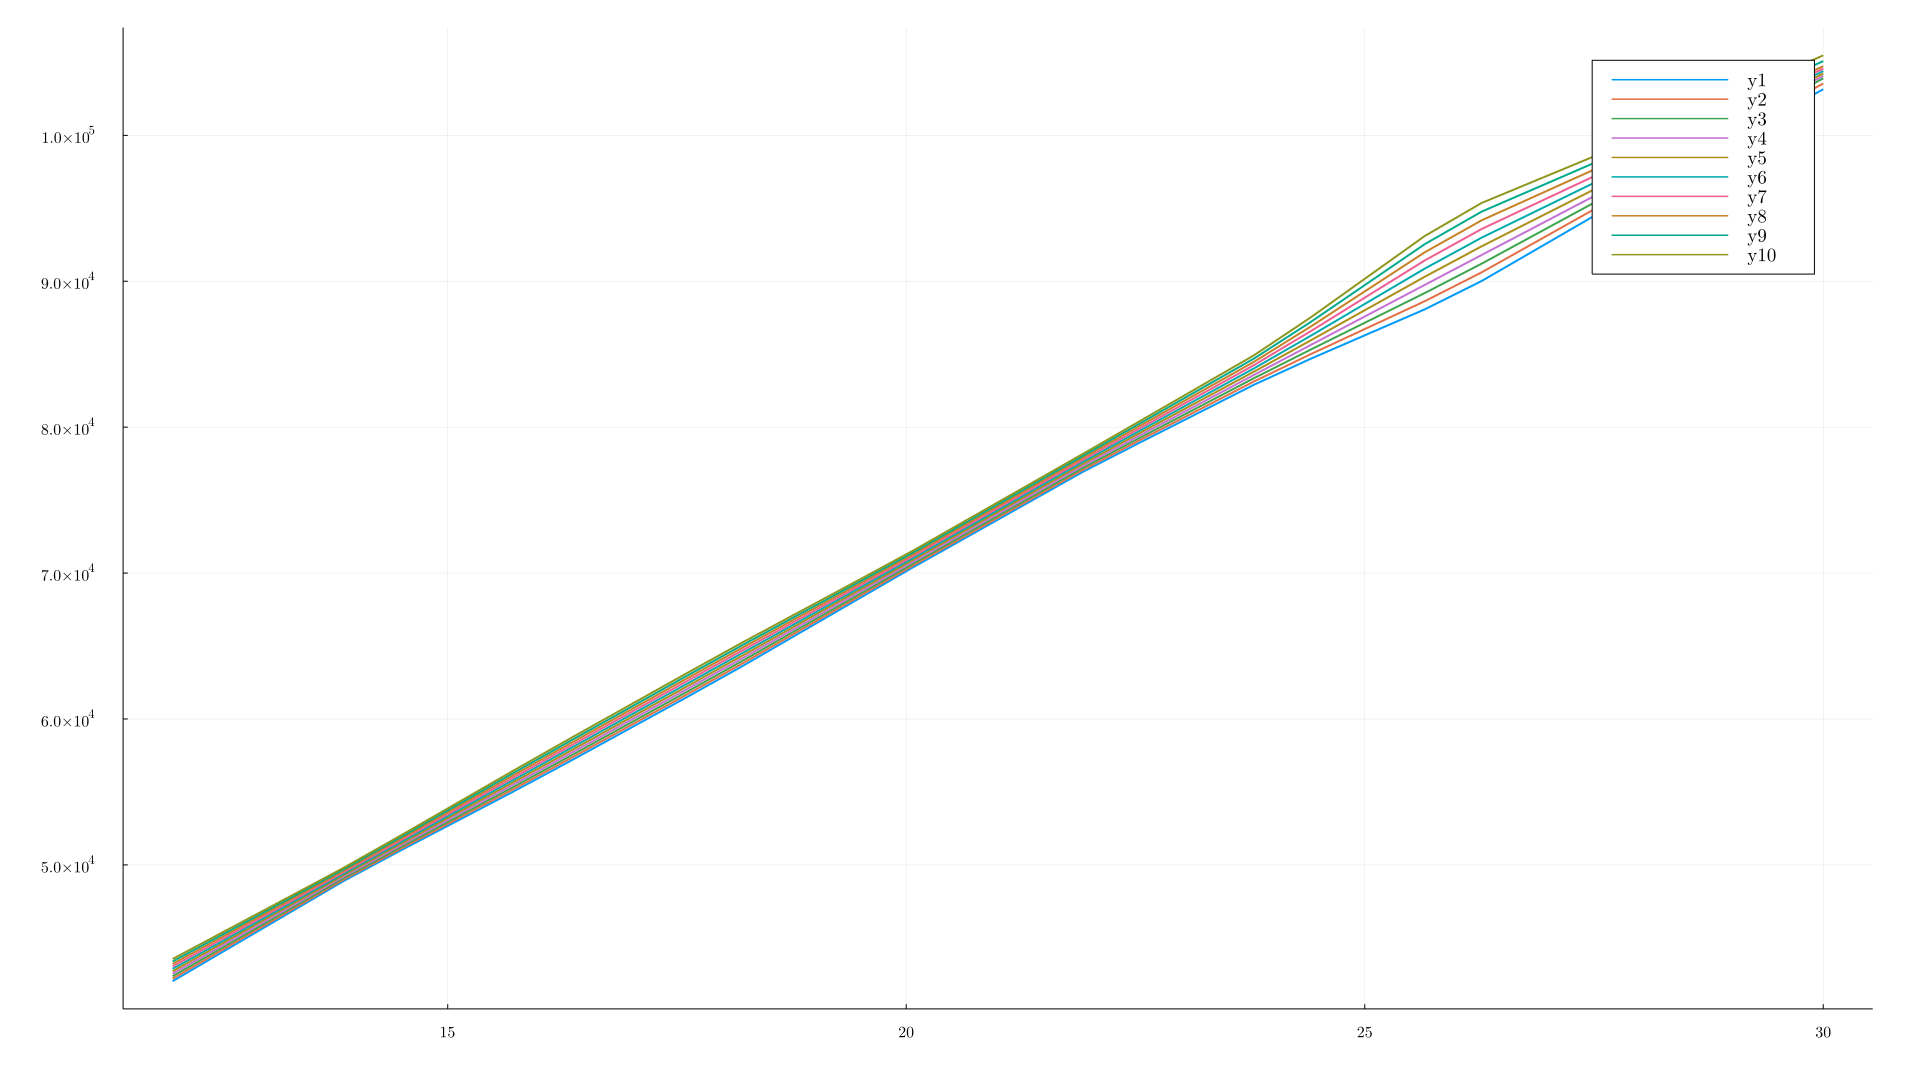

In [6]:
using Plots
n_plot = range(1500, 3000, length = 10)
MAP_plot = range(12, 30, length = 30)
p_wot_plot = [interp_p_wot(n,MAP) for (n,MAP) in Iterators.product(n_plot, MAP_plot)]
plot(MAP_plot, p_wot_plot')

We also need the inverse table $MAP_{wot}(n,p)$ for the $MAP(thr,p,n)$ computation.

To do this, we can proceed as we did for the part-throttle table: for each $n$ obtain a 1D linear interpolator MAP_wot_1D(p). Then evaluate it at some predefined $p$ range. Finally, use the results for all $n$ values to construct the 2D interpolator $MAP_{wot}(n, h)$.

In [18]:

p_range_wot = range(ISAData(AltGeop(ustrip(u"m", 23000u"ft"))).p, 101325, length = 100)

MAP_wot_data = Array{Float64}(undef, length(n_range), length(p_range_wot))
for (i, n) in enumerate(n_range)
    p_wot_1D = interp_p_wot(n, MAP_range_wot)
    interp_MAP_wot_1D = LinearInterpolation(p_wot_1D, MAP_range_wot, extrapolation_bc = Line())
    MAP_wot_data[i, :] = interp_MAP_wot_1D.(p_range_wot)
end

interp_MAP_wot = extrapolate(scale(interpolate(MAP_wot_data, BSpline(Linear())), n_range, p_range_wot), Line())

@show interp_MAP_wot(2400, 101325)
@show interp_MAP_wot(2800, 101325)
# @show interp_MAP_wot(2700, 8.25)

#this should return about 18
@show interp_MAP_wot(2400, ISAData(AltGeop(12250*0.3048)).p)
#OK


interp_MAP_wot(2400, 101325) = 28.957843553764317
interp_MAP_wot(2800, 101325) = 28.710638104794537
interp_MAP_wot(2400, (ISAData(AltGeop(12250 * 0.3048))).p) = 17.987616030352978


17.987616030352978

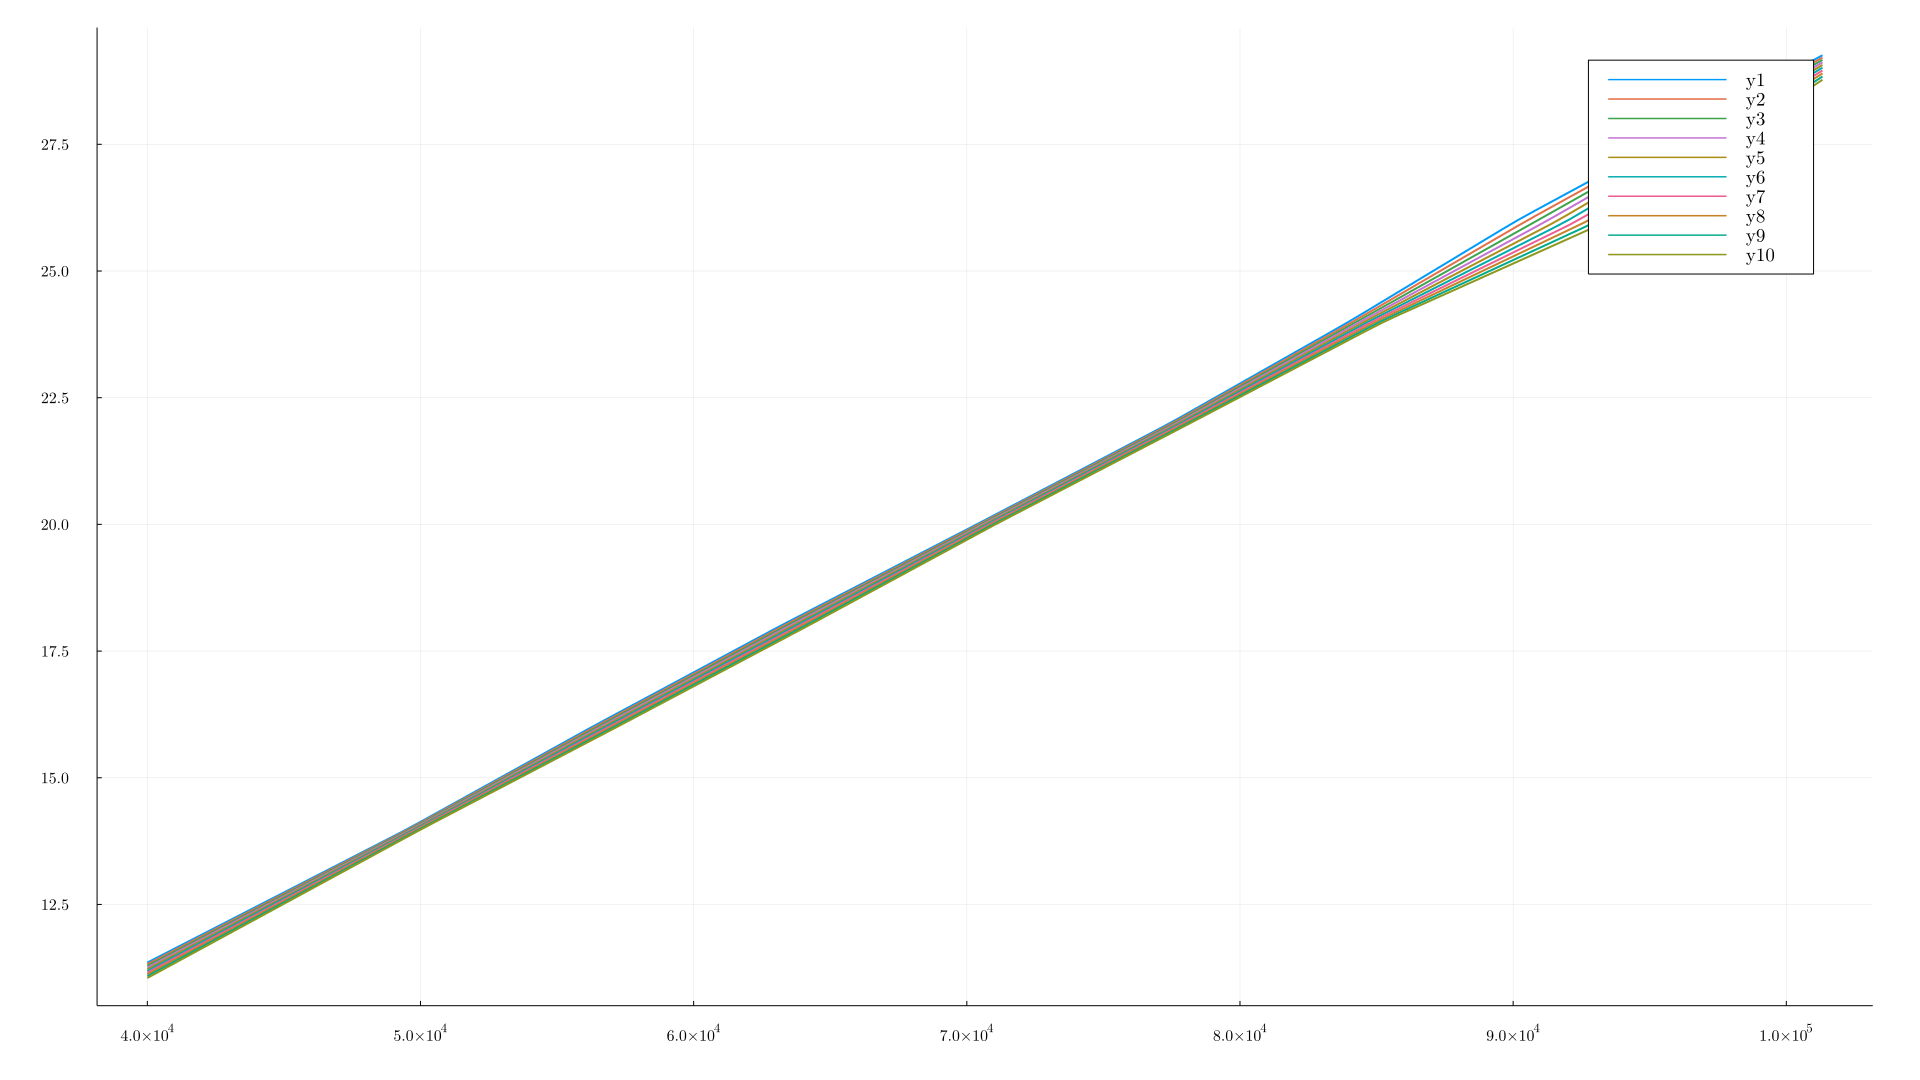

In [19]:
using Plots
n_plot = range(1800, 2700, step = 100)
p_plot = range(40000, 101325, length = 100)
MAP_wot_plot = [interp_MAP_wot(n,p) for (n,p) in Iterators.product(n_plot, p_plot)]
plot(p_plot, MAP_wot_plot')

Is it justified for the $MAP_{wot}(n,h)$ and $h_{wot}(n,MAP)$ mappings to be extrapolated linearly? To answer this, we can reason with $MAP_{wot}(n,h)$; since one mapping is the inverse of the other, and they are linear, the conclusion will apply for both of them. For a given $n$, as $h$ grows, $MAP_{wot}$ keeps falling indefinitely, since the air pressure keeps getting lower. And for a given $h$, as $n$ grows, $MAP_{wot}$ also keeps falling indefinitely, since the engine sucks air faster and the manifold vacuum increases. The fact that the brake power decreases due to increasing losses for $n > 2700$ does not change these facts.


In [20]:
#we interpolate linearly between pressures corresponding to 23kft and 0ft
p_range_wot_P = range(ISAData(AltGeop(ustrip(u"m", 23000u"ft"))).p, 101325, length = 2)

#read from the right graph
P̃_wot_data_23k = [46 51.5 56 59.9 63.8 66.2 70.6 76 78.6 81.8 81.8 78.6] |> vec

#to ensure consistency with P_std, to obtain the h=0 points we evaluate P_std(n,
#MAP) with MAP = MAP_wot(n), instead of reading them from the graph
P̃_wot_data_std = [interp_P̃_std(n, interp_MAP_wot(n, 101325)) for n in n_range_ext]

P̃_wot_data = hcat(P̃_wot_data_23k, P̃_wot_data_std)

interp_P̃_wot = extrapolate(scale(interpolate(P̃_wot_data, BSpline(Linear())), n_range_ext, p_range_wot_P), Line())

@show P̃_wot_data

#and these now should be equal
@show interp_P̃_wot(2400, 101325)
@show interp_P̃_std(2400, interp_MAP_wot(2400, 101325))


P̃_wot_data = [46.0 121.11254778230128; 51.5 130.2790038566798; 56.0 139.864990899522; 59.9 150.4942437910264; 63.8 157.71341274735815; 66.2 168.66576743462537; 70.6 177.60968199085556; 76.0 185.60385919719744; 78.6 194.60130896310037; 81.8 201.51298201658852; 81.8 201.3977601326278; 78.6 194.2356305406416]
interp_P̃_wot(2400, 101325) = 177.60968199085556
interp_P̃_std(2400, interp_MAP_wot(2400, 101325)) = 177.60968199085556


177.60968199085556

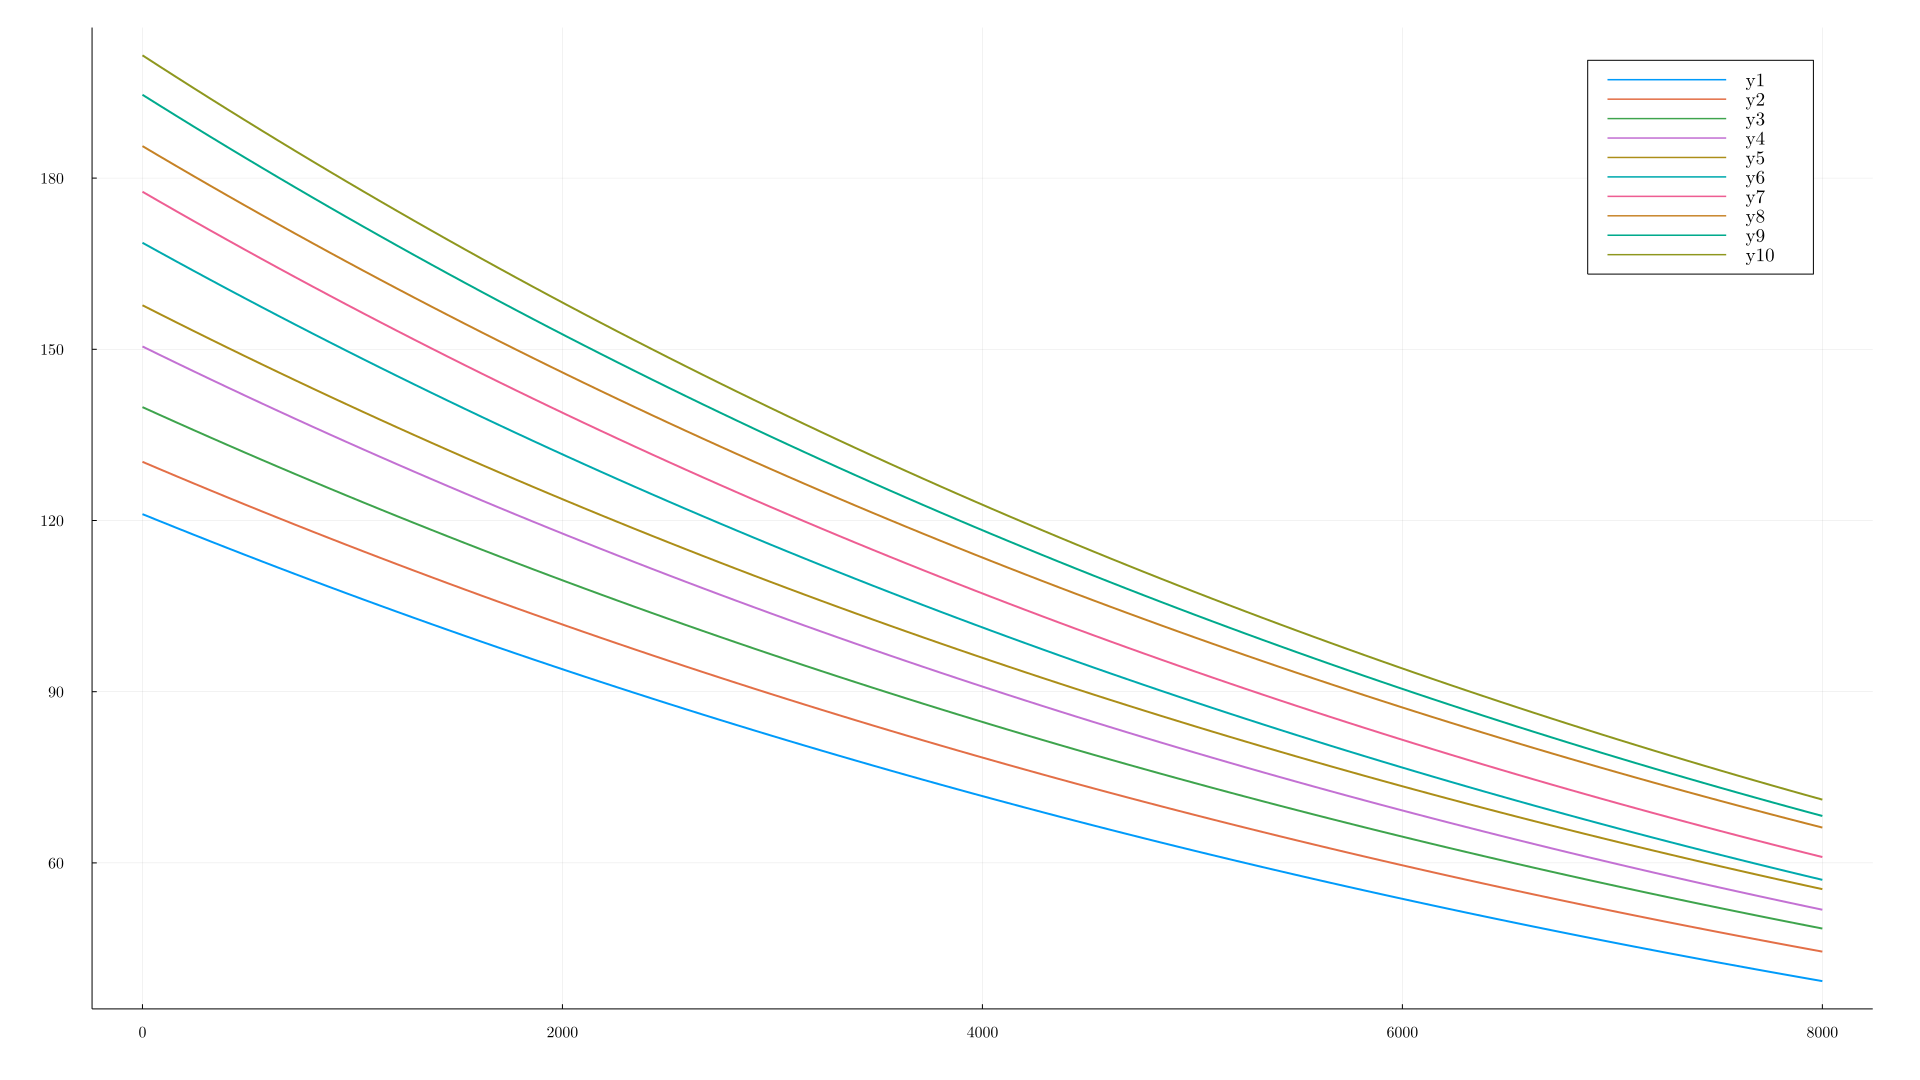

In [21]:
using Plots
n_plot = range(1800, 2700, step = 100)
h_plot = range(0, 8000, length = 100)
p_plot = StructArray(ISAData.(AltGeop.(h_plot))).p
P̃_wot_plot = [interp_P̃_wot(n,p) for (n,p) in Iterators.product(n_plot, p_plot)]
plot(h_plot,P̃_wot_plot')
#and here we see the non-linearity of P̃_wot with h

In [22]:
@show interp_P̃_wot(2700, (0 |> AltGeop |> ISAData).p)
@show interp_P̃_wot(2700, (5000 * 0.3048 |> AltGeop |> ISAData).p)
@show interp_P̃_wot(2900, (10000 * 0.3048 |> AltGeop |> ISAData).p)
@show interp_P̃_wot(1900, (15000 * 0.3048 |> AltGeop |> ISAData).p)

#the results match the graph with one to two hp of error, probably due to the
#assumption that P is linear with p

interp_P̃_wot(2700, ((0 |> AltGeop) |> ISAData).p) = 201.51298201658852
interp_P̃_wot(2700, ((5000 * 0.3048 |> AltGeop) |> ISAData).p) = 167.74149198484258
interp_P̃_wot(2900, ((10000 * 0.3048 |> AltGeop) |> ISAData).p) = 133.57855778090078
interp_P̃_wot(1900, ((15000 * 0.3048 |> AltGeop) |> ISAData).p) = 72.63155306936929


72.63155306936929

In [23]:
function compute_P̃(thr, n, p)
    #compute the wide-open throttle MAP for the given RPMs and altitude
    MAP_wot = interp_MAP_wot(n, p)
    idle_MAP_ratio = 0.4
    #this can be tuned so that the engine idles at appropriate RPMs with the
    #chosen propeller
    MAP = MAP_wot * (idle_MAP_ratio + thr * (1 - idle_MAP_ratio))

    #compute P̃ at standard conditions for the given RPMs and the resulting MAP
    p_std = 101325
    p_wot = interp_p_wot(n, MAP)

    #compute h_wot and P̃(n, h_wot)
    P̃_std = interp_P̃_std(n, MAP)
    P̃_wot = interp_P̃_wot(n, p_wot)

    #when p_wot is close to p_std with MAP = MAP_wot (thr = 1),
    #p_wot(MAP_wot(p_std)) = p_std and P̃_wot = P̃_std. we need to avoid the
    #division by zero
    @show abs(p_wot/p_std -1)
    if abs(p_wot/p_std - 1) < 1e-3
        @show "Hi"
        P̃ = P̃_std
    else
        P̃ = P̃_std + (P̃_wot - P̃_std) / (p_wot - p_std) * (p - p_std)
    end

    
    @show MAP_wot, MAP
    @show p, p_wot, p_std 
    @show P̃_std, P̃_wot
    @show P̃

    return max(0, P̃)

end


compute_P̃ (generic function with 1 method)

In [36]:
thr_test = 0.8
n_test = 2770
p_test = ISAData(AltGeop(1000*0.3048)).p
compute_P̃(thr_test, n_test, p_test)

abs(p_wot / p_std - 1) = 0.15164753762880134
(MAP_wot, MAP) = (27.443747047135496, 24.150497401479235)
(p, p_wot, p_std) = (97716.56711902257, 85959.3132497617, 101325)
(P̃_std, P̃_wot) = (161.5845219131458, 170.97702623786182)
P̃ = 163.79023012462568


163.79023012462568